<a href="https://colab.research.google.com/github/Derinhelm/graph_syntax_parsing/blob/experiments/dgl_pyg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

2.1.0+cu121
True
1
0
Tesla T4


In [ ]:
from IPython.display import clear_output

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


Установка dgl

In [ ]:
#!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

#clear_output()

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.0/926.0 MB 1.3 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=400f180a73a176e

In [ ]:
# use this to install CPU-only version
#!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl==0.9 dglgo -f https://data.dgl.ai/wheels/repo.html

#clear_output()

In [ ]:
import dgl
print(dgl.__version__)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
2.0.0+cu121


In [ ]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
print(os.getenv('DGLBACKEND'))

pytorch


In [ ]:
!printenv DGLBACKEND

pytorch


Установка pyg

In [ ]:
!pip install torch_geometric

clear_output()

Для создания эмбеддингов

In [ ]:
!pip install -q transformers

clear_output()

Для визуализации

In [ ]:
# graphviz is installed in Colab server, but need lib to work
# credits to: https://gist.github.com/korakot/a80c04a1945b06e2f4a053f92fecfbf9
!apt install libgraphviz-dev
!pip install pygraphviz

clear_output()

# Импорт библиотек

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

# Создание тестового предложения


In [ ]:
import re


numberRegex = re.compile("[0-9]+|[0-9]+\\.[0-9]+|[0-9]+[0-9,]+");
def normalize(word):
    return 'NUM' if numberRegex.match(word) else word.lower()


class ConllEntry:
    def __init__(self, id, form, lemma, pos, cpos, feats=None, parent_id=None, relation=None,
        deps=None, misc=None, treebank_id=None, proxy_tbank=None, language=None, char_rep=None):

        self.id = id
        self.form = form
        self.char_rep = char_rep if char_rep else form
        self.norm = normalize(self.char_rep)
        self.cpos = cpos
        self.pos = pos
        self.parent_id = parent_id
        self.relation = relation

        self.lemma = lemma
        self.feats = feats
        self.deps = deps
        self.misc = misc

        self.pred_parent_id = None
        self.pred_relation = None
        self.treebank_id = treebank_id
        self.proxy_tbank = proxy_tbank
        self.language = language

        self.pred_pos = None
        self.pred_cpos = None


    def __str__(self):
        values = [str(self.id), self.form, self.lemma, \
                  self.pred_cpos if self.pred_cpos else self.cpos,\
                  self.pred_pos if self.pred_pos else self.pos,\
                  self.feats, str(self.pred_parent_id) if self.pred_parent_id \
                  is not None else str(self.parent_id), self.pred_relation if\
                  self.pred_relation is not None else self.relation, \
                  self.deps, self.misc]
        return '\t'.join(['_' if v is None else v for v in values])


He_1 said_2 he_3 will_4 now_5 consider_6 those_7 offers_8 (.)_9


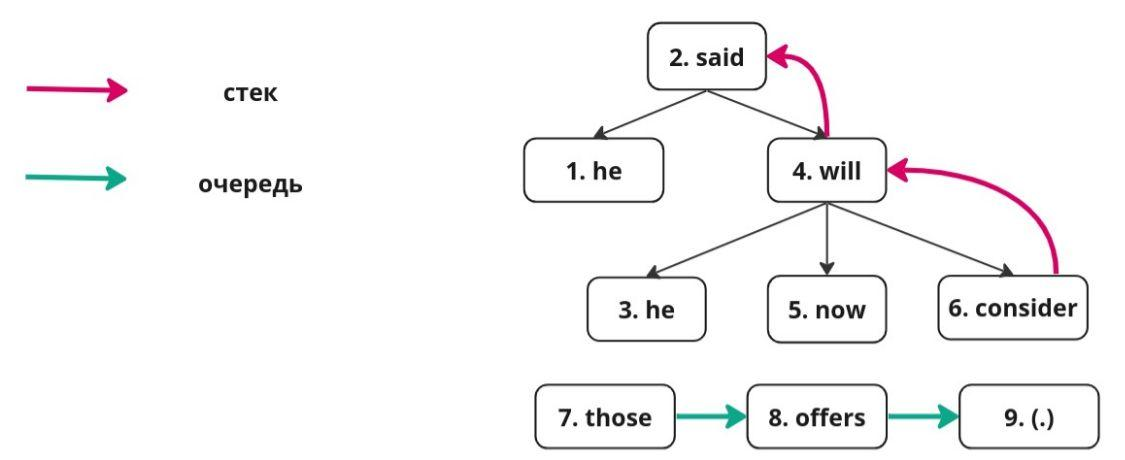

In [ ]:
def test_creating():
    he1 = ConllEntry(1, "he", "he", "", "", feats="", parent_id=2)
    said2 = ConllEntry(2, "said", "say", "", "", feats="", parent_id=0)
    he3 = ConllEntry(3, "he", "he", "", "", feats="", parent_id=4)
    will4 = ConllEntry(4, "will", "to be", "", "", feats="", parent_id=2)
    now5 = ConllEntry(5, "now", "now", "", "", feats="", parent_id=4)
    consider6 = ConllEntry(6, "consider", "consider", "", "", feats="", parent_id=4)
    those7 = ConllEntry(7, "those", "this", "", "", feats="")
    offers8 = ConllEntry(8, "offers", "offer", "", "", feats="")
    point9 = ConllEntry(9, ".", ".", "", "", feats="")

    sentence = [he1, said2, he3, will4, now5, consider6, those7, offers8, point9]
# TODO: проверить, где в исходном коде начало и конец очереди и стека
    stack = [consider6, will4, said2]
    buffer = [those7, offers8, point9]
    return sentence, stack, buffer

# Создание эмбеддингов

In [ ]:
def get_embed(tokenizer, model, word):
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state[0][0]
    return last_hidden_states.detach().cpu()

def embed_creating(sentence):
    word_embed_size = 312
    word_embeds = torch.empty((len(sentence), word_embed_size))

    tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
    model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
    for i in range(len(sentence)):
        word_embeds[i] = get_embed(tokenizer, model, sentence[i].form)
    print("word_embeds.shape:", word_embeds.shape)
    return word_embeds, word_embed_size

# DGL

## Создание DGL-графа

In [ ]:
import dgl
import dgl.nn.pytorch as dglnn
import dgl.nn.pytorch.conv as dglconv

In [ ]:
# В dgl - нумерация с 0, а в датасете - с 1

def dgl_graph_creating(sentence, stack, buffer, word_embeds):
    ts = time.time()
    graph_edges = []
    for node in sentence:
        if node.parent_id is not None and node.parent_id != 0:
            graph_edges.append((node.parent_id - 1, node.id - 1))
    stack_edges = []
    for i in range(len(stack) - 1): # Represents every two consecutive stack nodes as an edge
        stack_edges.append((stack[i].id - 1, stack[i + 1].id - 1))
    buffer_edges = []
    for i in range(len(buffer) - 1): # Represents every two consecutive buffer nodes as an edge
        buffer_edges.append((buffer[i].id - 1, buffer[i + 1].id - 1))
    data_dict = {
        ('node', 'graph', 'node'): tuple(zip(*graph_edges)),
        ('node', 'stack', 'node'): tuple(zip(*stack_edges)),
        ('node', 'buffer', 'node'): tuple(zip(*buffer_edges))
    }
    data_dict = {k: (torch.tensor(v[0]), torch.tensor(v[1])) for k, v in data_dict.items()}
    g = dgl.heterograph(data_dict)
    g.ndata["x"] = word_embeds
    graph_time = time.time() - ts
    return g, graph_time

## HeteroGraphConv

In [ ]:
def dgl_evaluate_conv(g, word_embed_size, output_size):
    feat = {'node': g.ndata["x"]}
    conv = dglnn.HeteroGraphConv({
        'buffer' : dglnn.GraphConv(word_embed_size, output_size, norm='both', weight=True, bias=True),
        'stack' : dglnn.GraphConv(word_embed_size, output_size, norm='both', weight=True, bias=True),
        'graph' : dglnn.GraphConv(word_embed_size, output_size, norm='both', weight=True, bias=True)},
        aggregate='sum')
    res_conv = conv(g, feat)
    return sum(res_conv["node"].clone().detach())

In [ ]:
def dgl_evaluate(g, word_embed_size, output_size, device):

    ts = time.time()
    conv = dglnn.HeteroGraphConv({
        'buffer' : dglnn.SAGEConv(word_embed_size, output_size, 'mean', bias=True),
        'stack' : dglnn.SAGEConv(word_embed_size, output_size, 'mean', bias=True),
        'graph' : dglnn.SAGEConv(word_embed_size, output_size, 'mean', bias=True)},
        aggregate='sum')
    model_time = time.time() - ts

    ts = time.time()
    conv = conv.to(device)
    device_g = g.to(device)
    device_time = time.time() - ts
    feat = {'node': device_g.ndata["x"]}
    ts = time.time()
    res_conv = conv(device_g, feat)
    res = sum(res_conv["node"].clone().detach().cpu())
    conv_time = time.time() - ts

    return res, model_time, device_time, conv_time

## Визуализация

In [ ]:
import cv2
import pygraphviz as pgv
from google.colab.patches import cv2_imshow

# helper function
def plot_dgl_graph(nxg, save_name):
    ag = pgv.AGraph(strict=False, directed=True)
    for edge_type in nxg._etypes:
        u, v = nxg[edge_type].edges()
        for i in range(len(u)):
            ag.add_edge(int(u[i]), int(v[i]), label=edge_type)
    ag.layout('dot')
    ag.draw(save_name+'.png')
    img = cv2.imread('base_graph.png')
    cv2_imshow(img)

# PYG

In [ ]:
import torch_geometric.nn
import torch_geometric.data

## Создание PYG-графа

In [ ]:
def create_stack_edges(stack):
    if len(stack) == 0:
        return torch.stack((torch.tensor([], dtype=torch.int32), \
                            torch.tensor([], dtype=torch.int32)), dim=0)
    stack_edges = []
    if len(stack) == 1:
        stack_edges.append((stack[0].id - 1, stack[0].id - 1)) # temporary solution
    else:
        for i in range(len(stack) - 1): # Represents every two consecutive stack nodes as an edge
            stack_edges.append((stack[i].id - 1, stack[i + 1].id - 1))
    stack_edges = tuple(zip(*stack_edges))
    stack_edges = [torch.tensor(stack_edges[0]), torch.tensor(stack_edges[1])]
    return torch.stack(stack_edges, dim=0)

def create_buffer_edges(buffer):
    if len(buffer) == 0 or len(buffer) == 1: # Last element is a technical root element.
        return torch.stack((torch.tensor([], dtype=torch.int32), \
                            torch.tensor([], dtype=torch.int32)), dim=0)
    buffer_edges = []
    if len(buffer) == 2: # Last element is a technical root element.
        buffer_edges.append((buffer[0].id - 1, buffer[0].id - 1)) # temporary solution
    else:
        for i in range(len(buffer) - 2): # Last element is a technical root element.
        # Represents every two consecutive buffer nodes as an edge
            buffer_edges.append((buffer[i].id - 1, buffer[i + 1].id - 1))
    buffer_edges = tuple(zip(*buffer_edges))
    buffer_edges = [torch.tensor(buffer_edges[0]), torch.tensor(buffer_edges[1])]
    return torch.stack(buffer_edges, dim=0)

def create_graph_edges(sentence):
    graph_edges = []
    for node in sentence:
        if node.pred_parent_id is not None and node.pred_parent_id != 0 \
            and node.pred_parent_id != -1:
            graph_edges.append((node.pred_parent_id - 1, node.id - 1))
    if len(graph_edges) == 0:
        return torch.stack((torch.tensor([], dtype=torch.int32), \
                            torch.tensor([], dtype=torch.int32)), dim=0)
    graph_edges = tuple(zip(*graph_edges))
    graph_edges = [torch.tensor(graph_edges[0]), torch.tensor(graph_edges[1])]
    return torch.stack(graph_edges, dim=0)

def pyg_graph_creating(sentence, stack, buffer, word_embeds):
    ts = time.time()
    data = torch_geometric.data.HeteroData()
    data['node']['x'] = word_embeds

    data[('node', 'graph', 'node')].edge_index = create_graph_edges(sentence)
    data[('node', 'stack', 'node')].edge_index = create_stack_edges(stack)
    data[('node', 'buffer', 'node')].edge_index = create_buffer_edges(buffer)
    graph_time = time.time() - ts

    return data, graph_time

## Hetero GNN

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, word_embed_size, output_size):
        super().__init__()
        self.conv1 = torch_geometric.nn.SAGEConv(word_embed_size, output_size)

    def forward(self, x, edge_index):
        return self.conv1(x, edge_index)


def pyg_evaluate(g, word_embed_size, output_size, device):
    ts = time.time()
    single_conv = GNN(word_embed_size, output_size)


    metadata = (['node'], [('node', 'graph', 'node'), ('node', 'stack', 'node'),\
                                     ('node', 'buffer', 'node')])
    conv = torch_geometric.nn.to_hetero(single_conv, metadata, aggr='sum')
    model_time = time.time() - ts

    ts = time.time()
    conv = conv.to(device)
    device_g = g.to(device)
    device_time = time.time() - ts

    ts = time.time()
    res_conv = conv(device_g.x_dict, device_g.edge_index_dict)
    res = torch.sum(res_conv['node'].clone().detach().cpu(), dim=0)
    conv_time = time.time() - ts

    return res, model_time, device_time, conv_time

# Запуск

In [ ]:
#random.seed(1)

In [ ]:
res_size = 4

In [ ]:
sentence, stack, buffer = test_creating()
word_embeds, word_embed_size = embed_creating(sentence)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

word_embeds.shape: torch.Size([9, 312])


In [ ]:
import time
from collections import defaultdict

In [ ]:
n = 1000

In [ ]:
res = {}

for device_type in ["cuda", "cpu"]:
  device = torch.device(device_type)
  task_key = device_type + "_dgl"
  res[task_key] = defaultdict(int)
  for _ in range(n):
      dgl_graph, graph_time = dgl_graph_creating(sentence, stack, buffer, word_embeds)
      dgl_res, model_time, device_time, conv_time = dgl_evaluate(dgl_graph, word_embed_size, res_size, device)
      res[task_key]["graph_time"] += graph_time
      res[task_key]["model_time"] += model_time
      res[task_key]["device_time"] += device_time
      res[task_key]["conv_time"] += conv_time

  task_key = device_type + "_pyg"
  res[task_key] = defaultdict(int)
  for _ in range(n):
      pyg_graph, graph_time = pyg_graph_creating(sentence, stack, buffer, word_embeds)
      pyg_res, model_time, device_time, conv_time = pyg_evaluate(pyg_graph, word_embed_size, res_size, device)
      res[task_key]["graph_time"] += graph_time
      res[task_key]["model_time"] += model_time
      res[task_key]["device_time"] += device_time
      res[task_key]["conv_time"] += conv_time

print(res)
for task_key, task_dict in res.items():
    for time_key, time_res in task_dict.items():
        res[task_key][time_key] /= n
print(res)


{'cuda_dgl': defaultdict(<class 'int'>, {'graph_time': 1.9273815155029297, 'model_time': 2.922762632369995, 'device_time': 1.6116528511047363, 'conv_time': 9.024582386016846}), 'cuda_pyg': defaultdict(<class 'int'>, {'graph_time': 0.5104928016662598, 'model_time': 17.72251319885254, 'device_time': 1.454887866973877, 'conv_time': 5.830046892166138}), 'cpu_dgl': defaultdict(<class 'int'>, {'graph_time': 0.890819787979126, 'model_time': 1.109222173690796, 'device_time': 0.16806674003601074, 'conv_time': 2.8683712482452393}), 'cpu_pyg': defaultdict(<class 'int'>, {'graph_time': 0.25005364418029785, 'model_time': 6.728993892669678, 'device_time': 0.20688748359680176, 'conv_time': 1.0463242530822754})}
{'cuda_dgl': defaultdict(<class 'int'>, {'graph_time': 0.0019273815155029298, 'model_time': 0.002922762632369995, 'device_time': 0.0016116528511047363, 'conv_time': 0.009024582386016845}), 'cuda_pyg': defaultdict(<class 'int'>, {'graph_time': 0.0005104928016662597, 'model_time': 0.017722513198

In [ ]:
from pandas import DataFrame

In [ ]:
lines = []
columns = []
for task_key, task_dict in res.items():
    lines.append(task_key)
    columns.append(task_dict)
df = DataFrame(columns, index=lines)

In [ ]:
df

,graph_time,model_time,device_time,conv_time
cuda_dgl,0.001927,0.002923,0.001612,0.009025
cuda_pyg,0.000510,0.017723,0.001455,0.005830
cpu_dgl,0.000891,0.001109,0.000168,0.002868
cpu_pyg,0.000250,0.006729,0.000207,0.001046


In [ ]:
#plot_dgl_graph(dgl_graph, 'base_graph')